# Critical fields in the $U(1) \times U(1)$ model of a relativistic superconductor coupled to a relativistic superfluid

In this notebook we implement all basic things that we need to compute the critical fields ($H_{c,1}$ and $H_{c,2}$).

First we import the packages. If you get an error, there is something wrong with your installation (likely pyopencl).

In [1]:
# Import minaun_cl and other packages
import sys
sys.path.append('..')

import time
import numpy as np
import minaun_cl.core as core

# Settings for hexagonal flux tube lattices
core.lys = np.sqrt(3.0)
core.use_single_flux_tube = False

We define a function that simply minimizes the free energy functional at fixed magnetic field $B$ for a given parameter dictionary `p` passed to the function. It returns the Gibbs free energy density of the flux tube phase $G_{\mathrm{flux}} / V$ and the ratios (rounded to a few decimal places) $G_\mathrm{flux} / G_\mathrm{COE}$ (the coexisting phase), $G_\mathrm{flux} / G_\mathrm{SF}$ (the superfluid phase). It also returns the external magnetic field $H_\mathrm{ext}$ at the given magnetic field $B$ and all the fields (condensates, gauge-invariant potentials) in a single vector `x`.

In [88]:
def minimize_G(p, quiet=True):
    if quiet:
        def _print(a):
            pass
        core.prnt = _print
    else:
        def _print(a):
            print(a)
        core.prnt = _print
        
    
    core.winding = p['winding']
    core.float_type = p['float_type']
    core.model = p['model']
    p['la'] = np.array(p['la_s']) + (np.array(p['la_e']) - np.array(p['la_s'])) * p['alpha']
    phi = 4 * np.pi / p['q']
    lr = np.sqrt(phi / p['b'] / np.sqrt(3))
    ny = [core.nny(n) for n in p['nx']]

    t0 = time.time()
    mg = core.MultigridMinimizer(p['nx'])
    results, x, b = mg.minimize(p['m'], p['mu'], p['la'], p['q'], p['h'], p['pa'], p['pb'],
                                lr, p['epsilon'], p['iters_per_step'], p['total_steps'])

    print("Took me {:d}s.".format(int(time.time() - t0)))

    # compute G_flux
    f_flux = results[-3]
    h_ext = results[-2]
    b_avg = results[-1]
    g_flux = f_flux - h_ext * b_avg / (4 * np.pi)

    # compute G_coe
    r01 = np.sqrt((p['mu'][0] ** 2 - p['m'][0] ** 2) / p['la'][0])
    r02 = np.sqrt((p['mu'][1] ** 2 - p['m'][1] ** 2) / p['la'][1])
    la1 = p['la'][0]
    la2 = p['la'][1]
    h = p['h']
    g_coe = - la1 * la2 * (la1 * r01 ** 4 + la2 * r02 ** 4 + 2 * h * r01 ** 2 * r02 ** 2) / (4 * la1 * la2 - 4 * h ** 2)

    # compute G_sf
    g_sf = - 0.25 * la2 * r02 ** 4 - h_ext ** 2 / (8 * np.pi)
    
    return g_flux, round(g_flux / g_coe, 8), round(g_flux / g_sf, 8), round(h_ext, 8), x, b

## Test case

We run a simple test to see if the code works as intended. To do this, we define a parameter dictionary and run the function defined above. To understand these parameters, take a look at [arXiv:1704.01575](https://arxiv.org/abs/1704.01575).

In [11]:
# params
p = {
    # physical parameters
    'm': [1.0, 1.0],                               # masses of the particles
    'mu': [1.5, 1.8],                              # chemical potentials
    'la_s': [0.25, 1.20],                          # start position of self-coupling constants
    'la_e': [0.10, 0.10],                          # end position of self-coupling constants
    'alpha': 0.330,                                # 0 sets self-coupling to start values, 1 to end values
    'q': 0.17,                                     # charge of the charged particles
    'h': -0.1,                                     # density coupling constant
    'winding': 1,                                  # the winding number of flux tubes, standard is 1
    'b': 5.5,                                      # the average internal magnetic field

    # numerical parameters
    'gpu': 0,                                      # select specific GPU device
    'float_type': 'double',                        # 'float' or 'double' for precision
    'model': 'o4',                                 # 'o2' or 'o4' for numerical model setting
    'iters_per_step': 1000,                        # GPU iterations before checks on CPU 
    'total_steps': 100000,                         # total steps before stopping the program
    'nx': [128, 256, 512],                         # grid sizes to use in the multigrid minimizer
    'pa': [0.34, 0.34, 0.13, 0.13],                # parameters for heavy-ball method (always 4)
    'pb': [0.99, 0.99, 0.99, 0.99],                # parameters for heavy-ball method (always 4)
    'epsilon': [1E-9, 5*1E-11, 5*1E-12],           # stopping criterion based on relative changes in G or F (see paper)
}

In [17]:
# Settings for hexagonal flux tube lattices
core.lys = np.sqrt(3.0)
core.use_single_flux_tube = False

g_flux, r_coe, r_sf, h_ext, x, b = minimize_G(p)

Took me 66s.


# Basic plotting

Using these results we can plot various quantities such as the condensates or the local (internal) magnetic field.

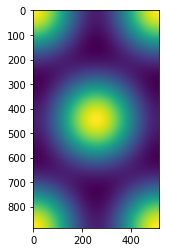

In [27]:
import matplotlib.pyplot as plt

nx = p['nx'][-1]
ny = core.nny(nx)

b_reshaped = b.reshape((ny, nx))

plt.imshow(b_reshaped)

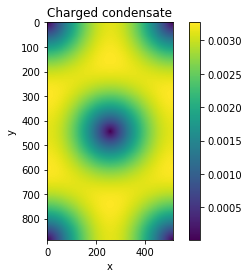

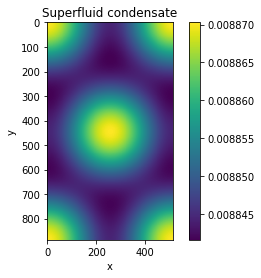

In [37]:
nx = p['nx'][-1]
ny = core.nny(nx)

phi1 = x[0::4].reshape((ny, nx))
phi2 = x[1::4].reshape((ny, nx))
Qx = x[2::4].reshape((ny, nx))
Qy = x[3::4].reshape((ny, nx))

plt.imshow(phi1)
plt.colorbar()
plt.title("Charged condensate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.imshow(phi2)
plt.colorbar()
plt.title("Superfluid condensate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

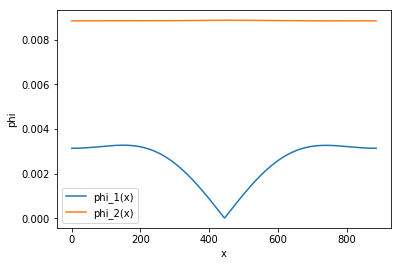

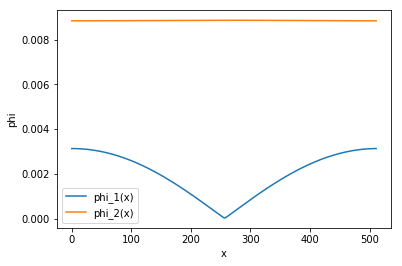

In [85]:
plt.plot(phi1[:, nx // 2], label="phi_1(x)")
plt.plot(phi2[:, nx // 2], label="phi_2(x)")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend()
plt.show()

plt.plot(phi1[ny // 2, :], label="phi_1(x)")
plt.plot(phi2[ny // 2, :], label="phi_2(x)")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend()
plt.show()

# Critical magnetic field $H_{c,2}$

In this part of the notebook we compute the transition from the flux tube phase to the superfluid phase using a bisection method. We define a function that computes an approximation to $H_{c,2}$ using an initial bisection interval $[B_{0,\mathrm{ini}}, B_{1,\mathrm{ini}}]$. It is necessary that there is some $B$ inside that interval such that $H(B) = H_{c,2}$. 

In [78]:
def Hc2_bisec(p, B0ini, B1ini, H_accuracy=0.01, B_accuracy=0.01, max_bisections=100):
    B0 = B0ini
    B1 = B1ini
    
    p0 = p.copy()
    p0['b'] = B0
    
    p1 = p.copy()
    p1['b'] = B1
    
    # return arguments of minimize_G:
    # g_flux, r_coe, r_sf, h_ext, x, b
    # We only take the arguments that we need:
    _, _, r_sf_0, h_0, _, _ = minimize_G(p0)
    _, _, r_sf_1, h_1, _, _ = minimize_G(p1)
    
    print("Starting interval [{:3.2f}, {:3.2f}] yields ratios:".format(B0ini, B1ini))
    print(r_sf_0, r_sf_1)
    
    if (r_sf_0 - 1.0) * (r_sf_1 - 1.0) > 0.0:
        print("The bisection interval for does not make any sense.")
        print(p)
        return
    
    for i in range(max_bisections):
        # Compute within bisection interval
        BN = np.sqrt(B0 * B1)
        pn = p.copy()
        pn['b'] = BN
        
        _, _, r_sf_n, h_n, _, _ = minimize_G(pn)
        
        print("H = [{:3.4f}, {:3.4f}, {:3.4f}], B = [{:3.4f}, {:3.4f}, {:3.4f}], G/G_sf = [{:3.9f}, {:3.9f}, {:3.9f}]".format(
        h_0, h_n, h_1, B0, BN, B1, r_sf_0, r_sf_n, r_sf_1))
        
        # Check if accuracy was reached
        H_rel_acc = abs(h_0 - h_1) / h_n
        B_rel_acc = abs(B0 - B1) / BN

        print("H_accuracy = {:3.4f}, B_accuracy = {:3.4f}".format(H_rel_acc, B_rel_acc))

        if H_rel_acc < H_accuracy and B_rel_acc < B_accuracy:
            break

        # Otherwise, continue with bisection
        if r_sf_n > 1.0:
            B0 = BN
            r_sf_0 = r_sf_n
            h_0 = h_n
        else:
            B1 = BN
            r_sf_1 = r_sf_n
            h_1 = h_n
    
    print("Finished!")
    
    return (B0, BN, B1), (h_0, h_n, h_1), (r_sf_0, r_sf_n, r_sf_1)

In [79]:
# params
p = {
    # physical parameters
    'm': [1.0, 1.0],                               # masses of the particles
    'mu': [1.5, 1.8],                              # chemical potentials
    'la_s': [0.25, 1.20],                          # start position of self-coupling constants
    'la_e': [0.10, 0.10],                          # end position of self-coupling constants
    'alpha': 0.360,                                # 0 sets self-coupling to start values, 1 to end values
    'q': 0.17,                                     # charge of the charged particles
    'h': -0.1,                                     # density coupling constant
    'winding': 1,                                  # the winding number of flux tubes, standard is 1
    'b': 5.5,                                      # the average internal magnetic field

    # numerical parameters
    'gpu': 0,                                      # select specific GPU device
    'float_type': 'double',                        # 'float' or 'double' for precision
    'model': 'o4',                                 # 'o2' or 'o4' for numerical model setting
    'iters_per_step': 1000,                        # GPU iterations before checks on CPU 
    'total_steps': 100000,                         # total steps before stopping the program
    'nx': [128, 256],                              # grid sizes to use in the multigrid minimizer
    'pa': [0.34, 0.34, 0.13, 0.13],                # parameters for heavy-ball method (always 4)
    'pb': [0.99, 0.99, 0.99, 0.99],                # parameters for heavy-ball method (always 4)
    'epsilon': [1E-9, 1E-12],                      # stopping criterion based on relative changes in G or F (see paper)
}

# Settings for hexagonal flux tube lattices
core.lys = np.sqrt(3.0)
core.use_single_flux_tube = False

B_interval, H_interval, G_interval = Hc2_bisec(p, 5.65, 5.80, H_accuracy=0.001, B_accuracy=0.001)

Took me 29s.
Took me 13s.
Starting interval [5.65, 5.80] yields ratios:
(1.00000107, 1.0)
Took me 106s.
H = [5.7132, 5.7245, 5.8000], B = [5.6500, 5.7245, 5.8000], G/G_sf = [1.000001070, 1.000000000, 1.000000000]
H_accuracy = 0.0152, B_accuracy = 0.0262
Took me 61s.
H = [5.7132, 5.7139, 5.7245], B = [5.6500, 5.6871, 5.7245], G/G_sf = [1.000001070, 1.000000190, 1.000000000]
H_accuracy = 0.0020, B_accuracy = 0.0131
Took me 134s.
H = [5.7139, 5.7142, 5.7245], B = [5.6871, 5.7058, 5.7245], G/G_sf = [1.000000190, 1.000000020, 1.000000000]
H_accuracy = 0.0019, B_accuracy = 0.0066


KeyboardInterrupt: 

In [ ]:
print("B = ", B_interval)
print("B = ", H_interval)
print("G/G_sf = ", G_interval)

# Critical magnetic field $H^{(')}_{c,1}$

Now we define a very similar function to determine $H_{c,1}$ using bisection.

In [83]:
def Hc1_bisec(p, B0ini, B1ini, H_accuracy=0.01, B_accuracy=0.01, max_bisections=100):
    B0 = B0ini
    B1 = B1ini
    
    p0 = p.copy()
    p0['b'] = B0
    
    p1 = p.copy()
    p1['b'] = B1
    
    # return arguments of minimize_G:
    # g_flux, r_coe, r_sf, h_ext, x, b
    # We only take the arguments that we need:
    _, r_coe_0, _, h_0, _, _ = minimize_G(p0)
    _, r_coe_1, _, h_1, _, _ = minimize_G(p1)
    
    print("Starting interval [{:3.2f}, {:3.2f}] yields ratios:".format(B0ini, B1ini))
    print(r_coe_0, r_coe_1)
    
    if (r_coe_0 - 1.0) * (r_coe_1 - 1.0) > 0.0:
        print("The bisection interval for does not make any sense.")
        print(p)
        return
    
    for i in range(max_bisections):
        # Compute within bisection interval
        BN = np.sqrt(B0 * B1)
        pn = p.copy()
        pn['b'] = BN
        
        _, r_coe_n, _, h_n, _, _ = minimize_G(pn)
        
        print("H = [{:3.4f}, {:3.4f}, {:3.4f}], B = [{:3.4f}, {:3.4f}, {:3.4f}], G/G_sf = [{:3.9f}, {:3.9f}, {:3.9f}]".format(
        h_0, h_n, h_1, B0, BN, B1, r_coe_0, r_coe_n, r_coe_1))
        
        # Check if accuracy was reached
        H_rel_acc = abs(h_0 - h_1) / h_n
        B_rel_acc = abs(B0 - B1) / BN

        print("H_accuracy = {:3.4f}, B_accuracy = {:3.4f}".format(H_rel_acc, B_rel_acc))

        if H_rel_acc < H_accuracy and B_rel_acc < B_accuracy:
            break

        # Otherwise, continue with bisection
        if r_coe_n < 1.0:
            B0 = BN
            r_coe_0 = r_coe_n
            h_0 = h_n
        else:
            B1 = BN
            r_coe_1 = r_coe_n
            h_1 = h_n
    
    print("Finished!")
    
    return (B0, BN, B1), (h_0, h_n, h_1), (r_coe_0, r_coe_n, r_coe_1)

In [82]:
# params
p = {
    # physical parameters
    'm': [1.0, 1.0],                               # masses of the particles
    'mu': [1.5, 1.8],                              # chemical potentials
    'la_s': [0.25, 1.20],                          # start position of self-coupling constants
    'la_e': [0.10, 0.10],                          # end position of self-coupling constants
    'alpha': 0.360,                                # 0 sets self-coupling to start values, 1 to end values
    'q': 0.17,                                     # charge of the charged particles
    'h': -0.1,                                     # density coupling constant
    'winding': 1,                                  # the winding number of flux tubes, standard is 1
    'b': 5.5,                                      # the average internal magnetic field

    # numerical parameters
    'gpu': 0,                                      # select specific GPU device
    'float_type': 'double',                        # 'float' or 'double' for precision
    'model': 'o2',                                 # 'o2' or 'o4' for numerical model setting
    'iters_per_step': 1000,                        # GPU iterations before checks on CPU 
    'total_steps': 100000,                         # total steps before stopping the program
    'nx': [128, 256],                              # grid sizes to use in the multigrid minimizer
    'pa': [0.34, 0.34, 0.13, 0.13],                # parameters for heavy-ball method (always 4)
    'pb': [0.99, 0.99, 0.99, 0.99],                # parameters for heavy-ball method (always 4)
    'epsilon': [1E-9, 1E-11],                      # stopping criterion based on relative changes in G or F (see paper)
}

# Settings for hexagonal flux tube lattices
core.lys = np.sqrt(3.0)
core.use_single_flux_tube = False

B_interval, H_interval, G_interval = Hc1_bisec(p, 0.1, 3.80, H_accuracy=0.001, B_accuracy=0.001)

Took me 2s.
Took me 5s.
Starting interval [0.10, 3.80] yields ratios:
(0.99997353, 1.00067024)
Took me 4s.
H = [5.6817, 5.6793, 5.6827], B = [0.1000, 0.6164, 3.8000], G/G_sf = [0.999973530, 0.999955360, 1.000670240]
H_accuracy = 0.0002, B_accuracy = 6.0022
Took me 7s.
H = [5.6793, 5.6739, 5.6827], B = [0.6164, 1.5305, 3.8000], G/G_sf = [0.999955360, 0.999789130, 1.000670240]
H_accuracy = 0.0006, B_accuracy = 2.0801
Took me 9s.
H = [5.6739, 5.6722, 5.6827], B = [1.5305, 2.4116, 3.8000], G/G_sf = [0.999789130, 0.999714090, 1.000670240]
H_accuracy = 0.0016, B_accuracy = 0.9411
Took me 8s.
H = [5.6722, 5.6752, 5.6827], B = [2.4116, 3.0272, 3.8000], G/G_sf = [0.999714090, 0.999941980, 1.000670240]
H_accuracy = 0.0018, B_accuracy = 0.4586
Took me 7s.
H = [5.6752, 5.6783, 5.6827], B = [3.0272, 3.3917, 3.8000], G/G_sf = [0.999941980, 1.000220800, 1.000670240]
H_accuracy = 0.0013, B_accuracy = 0.2278
Took me 9s.
H = [5.6752, 5.6766, 5.6783], B = [3.0272, 3.2043, 3.3917], G/G_sf = [0.999941980, 

NameError: global name 'r_sf_0' is not defined

# Extracting flux tube profiles


In [128]:
# params
p = {
    # physical parameters
    'm': [1.0, 1.0],                               # masses of the particles
    'mu': [1.5, 1.8],                              # chemical potentials
    'la_s': [0.25, 1.20],                          # start position of self-coupling constants
    'la_e': [0.10, 0.10],                          # end position of self-coupling constants
    'alpha': 0.360,                                # 0 sets self-coupling to start values, 1 to end values
    'q': 0.17,                                     # charge of the charged particles
    'h': -0.1,                                     # density coupling constant
    'winding': 1,                                  # the winding number of flux tubes, standard is 1
    'b': 0.1,                                      # the average internal magnetic field

    # numerical parameters
    'gpu': 0,                                      # select specific GPU device
    'float_type': 'double',                        # 'float' or 'double' for precision
    'model': 'o2',                                 # 'o2' or 'o4' for numerical model setting
    'iters_per_step': 1000,                        # GPU iterations before checks on CPU 
    'total_steps': 100000,                         # total steps before stopping the program
    'nx': [128, 256, 512],                         # grid sizes to use in the multigrid minimizer
    'pa': [0.34, 0.34, 0.13, 0.13],                # parameters for heavy-ball method (always 4)
    'pb': [0.99, 0.99, 0.99, 0.99],                # parameters for heavy-ball method (always 4)
    'epsilon': [1E-9, 1E-11, 1E-11],               # stopping criterion based on relative changes in G or F (see paper)
}

# 'Single' flux tubes on quadratic lattice
core.lys = 1.0
core.use_single_flux_tube = True

In [129]:
g_flux, r_coe, r_sf, h_ext, x, b = minimize_G(p, quiet=False)

Grid no. 1
Creating Cx, Cy initial conditions from FFT.
Done.
0000: |dF| = 1.00E-03, |dG| = 1.00E-03, F/V = -2.805950, G/V = -2.845185, H_ext = 5.693077, n=4224/s @ 128x128
0001: |dF| = 1.36E-09, |dG| = 8.67E-09, F/V = -2.805954, G/V = -2.845160, H_ext = 5.688945, n=4418/s @ 128x128
0002: |dF| = 5.34E-14, |dG| = 6.37E-11, F/V = -2.805954, G/V = -2.845160, H_ext = 5.688971, n=4402/s @ 128x128
F/V = -2.80595391329.
H_ext = 5.68897137023.
B_avg = 0.0866025403784.
Interpolation no. 1
Grid no. 2
Creating Cx, Cy initial conditions from FFT.
Done.
0000: |dF| = 1.00E-03, |dG| = 1.00E-03, F/V = -2.806106, G/V = -2.845237, H_ext = 5.678150, n=4192/s @ 256x256
0001: |dF| = 4.22E-10, |dG| = 9.03E-09, F/V = -2.806107, G/V = -2.845263, H_ext = 5.681707, n=4123/s @ 256x256
0002: |dF| = 7.96E-14, |dG| = 4.42E-13, F/V = -2.806107, G/V = -2.845263, H_ext = 5.681707, n=3960/s @ 256x256
F/V = -2.80610679091.
H_ext = 5.6817073832.
B_avg = 0.0866025403784.
Interpolation no. 2
Grid no. 3
Creating Cx, Cy init

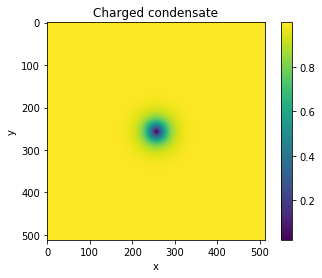

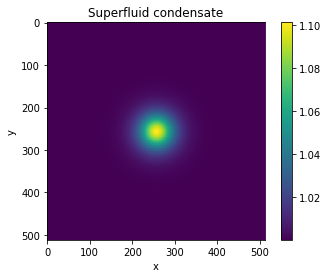

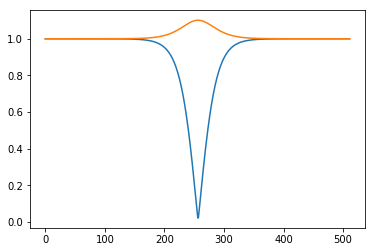

In [131]:
nx = p['nx'][-1]
ny = core.nny(nx)

phi1 = x[0::4].reshape((ny, nx))
phi2 = x[1::4].reshape((ny, nx))
Qx = x[2::4].reshape((ny, nx))
Qy = x[3::4].reshape((ny, nx))

# convert to dimensionless quantities using \rho_01 and \rho_02
rsc = np.sqrt((p['mu'][0] ** 2 - p['m'][0] ** 2) / p['la'][0]) 
rsf = np.sqrt((p['mu'][1] ** 2 - p['m'][1] ** 2) / p['la'][1])

r01 = np.sqrt(p['la'][1] * (p['la'][0] * rsc ** 2 + p['h'] * rsf ** 2) / (p['la'][1] * p['la'][0] - p['h'] ** 2))
r02 = np.sqrt(p['la'][0] * (p['la'][1] * rsf ** 2 + p['h'] * rsc ** 2) / (p['la'][1] * p['la'][0] - p['h'] ** 2))

mag_flux = 4 * np.pi / p['q']
lr = np.sqrt(mag_flux / p['b'] / np.sqrt(3))
lattice_spacing = lr / nx

# shift flux tube center
phi1 = np.roll(np.roll(phi1, shift=ny//2, axis=0), shift=nx//2, axis=1) / r01 / lattice_spacing
phi2 = np.roll(np.roll(phi2, shift=ny//2, axis=0), shift=nx//2, axis=1) / r02 / lattice_spacing

plt.imshow(phi1)
plt.colorbar()
plt.title("Charged condensate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.imshow(phi2)
plt.colorbar()
plt.title("Superfluid condensate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.plot(phi1[ny//2, :])
plt.plot(phi2[ny//2, :])
plt.show()

In [132]:
# Save to table using np.savetxt
# These can be read using `Import["phi1_profile.dat"]`

np.savetxt("phi1_profile.dat", phi1)
np.savetxt("phi2_profile.dat", phi2)